# Agent-based model

This is a model of embryonic neocortex population, using an agent-based framework.
This means that we create cells, on we sample a Tc from the age-related distribution.
At the end of cell cycle, the fate decision for the daughters are.

The model starts at E48, where we have the first data.

Data will be of different types :

Tc:
- Population level estimation
- Cell level estimation

Differentiation:
- Cell level estimation

Number of progenitors:
- Ki67 ratio in GZ
- Ratio of Tbr2+ and Sox2+

Number of cells:
- Relative volume from Histo + MRI
- Density of cells

We will have to discuss quality of the data

In [1]:
# imports
import numpy as np
import seaborn as sns
import tqdm
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
from numpy.random import choice
from scipy.interpolate import splev, splrep, interp1d
from scipy import stats
from gpn4 import GrowingPlanarNetwork
from collections import Counter
from model import AbstractCell, Action, Brain, Submodels
from experiment import Experiment
from utils import nop, highest_lower, Profiler, plot_function
from submodels.cellbasic1 import CellBasic
from submodels.bistate1 import BiStateModelFactory
from submodels.bistate_LI import BiStateLIModelFactory
from submodels import factories
from tree import tree_from_cell

## Loading data

In [1]:
# Volume MRI + Histo
volumes = pd.read_csv('data/VolumeArea17.csv')

NameError: name 'pd' is not defined

## Preprocessing data

In [3]:
# from PolynomRegression
Tc_ = lambda time: 277.36424309532794 - 0.023973977538587 * time - 0.761568634472077 * time**2 + \
    0.025594287611410 * time**3 - 0.000307496975562 * time**4 + 0.000001264230759 * time**5
print("Polynom Reg", Tc_(48), Tc_(65), Tc_(78))

Polynom Reg 41.8919627067869 64.8715873071742 55.96794765296363


In [4]:
# what we do is to average some ages
volumes = volumes.append(volumes.loc[volumes.Age.isin([70, 72])].mean(), ignore_index=True)
volumes = volumes.append(volumes.loc[volumes.Age.isin([78, 79])].mean(), ignore_index=True)
volumes = volumes.append(volumes.loc[volumes.Age.isin([84, 86])].mean(), ignore_index=True)
volumes = volumes.loc[~volumes.Age.isin([70, 72, 78, 79, 84, 86])]

In [5]:
col = volumes.loc[:, ["Ratio_Histo_VZ", "Ratio_MRI_VZ"]]
volumes['Ratio_VZ'] = col.mean(axis=1)
col = volumes.loc[:, ["Ratio_Histo_ISVZ", "Ratio_MRI_ISVZ"]]
volumes['Ratio_ISVZ'] = col.mean(axis=1) * volumes.loc[0, "Histo_ISVZ"] / volumes.loc[0, "Histo_VZ"]
col = volumes.loc[:, ["Ratio_Histo_OSVZ", "Ratio_MRI_OSVZ"]]
volumes['Ratio_OSVZ'] = col.mean(axis=1) * volumes.loc[0, "Histo_OSVZ"] / volumes.loc[0, "Histo_VZ"]

In [6]:
volumes.loc[:, ["AverageDensityVZ", "AverageDensityISVZ", "AverageDensityOSVZ"]] /= \
    volumes.loc[0, "AverageDensityVZ"]
volumes["total_cell_number"] = volumes["AverageDensityVZ"] * volumes["Ratio_VZ"] + \
                               volumes["AverageDensityISVZ"] * volumes["Ratio_ISVZ"] + \
                               volumes["AverageDensityOSVZ"] * volumes["Ratio_OSVZ"]
volumes.head()

,Age,Histo_VZ,Histo_ISVZ,Histo_OSVZ,Histo_SP,Histo_CP,MRI_VZ,MRI_ISVZ,MRI_OSVZ,MRI_SP,...,RelativeDensityVZ,RelativeDensityISVZ,RelativeDensityOSVZ,AverageDensityVZ,AverageDensityISVZ,AverageDensityOSVZ,Ratio_VZ,Ratio_ISVZ,Ratio_OSVZ,total_cell_number
0,49.0,0.264,0.118,0.012,NaN,0.056,0.527,0.236,0.024,NaN,...,1.000,1.00,1.000,1.000000,0.441331,0.044134,1.0000,0.446970,0.045455,1.199268
1,63.0,0.716,0.428,3.666,NaN,2.284,1.161,0.698,5.871,4.807,...,0.820,1.34,10.540,0.821235,0.592874,0.465094,2.4590,1.474330,12.733250,8.815673
8,94.0,0.910,0.767,6.152,NaN,15.344,NaN,NaN,NaN,NaN,...,0.230,0.28,2.800,0.234263,0.121405,0.123754,3.4520,2.909773,23.732864,4.098968
9,71.0,0.615,0.498,5.095,NaN,3.962,1.880,1.486,15.337,17.782,...,0.545,0.93,7.330,0.542118,0.409147,0.323570,2.9495,2.352625,24.617727,10.527115
10,78.5,0.374,0.342,4.686,NaN,5.366,1.030,0.957,12.835,17.322,...,0.480,0.88,5.495,0.477197,0.387065,0.242614,1.6895,1.556795,21.415750,6.604573


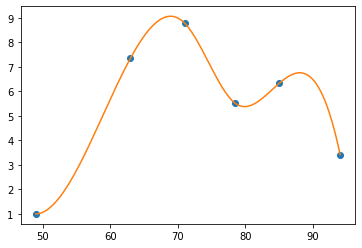

In [7]:
# complicated stuff to sort the list
sorted_number_cells = tuple(zip(*tuple(sorted(list(zip(volumes["Age"],
                                                       volumes["total_cell_number"] /
                                                       volumes.loc[0, "total_cell_number"])),
                                              key=lambda x: x[0]))))
spl = splrep(*sorted_number_cells)
x2 = np.linspace(49, 94, 200)
y2 = splev(x2, spl)
plt.plot(*sorted_number_cells, 'o', x2, y2)
plt.show()

In [8]:
def callback():
    plt.plot(*sorted_number_cells, 'o', x2, y2)

In [9]:
# Cell fate will be the first parameter to tune

### Ratio Tbr2

In [10]:
# From Betizeau et al.

ratio_eomes = pd.DataFrame({"VZ": [16.6, 13.3, 20, 43.3, 58.3],
                            "ISVZ": [88.3, 81.6, 81.6, 83.3, 75.0],
                            "OSVZ": [63.3, 43.3, 56.6, 63.3, 10.0],
                            "ratio_VZ": [43.2, 25, 12.5, 11.3, 10.2],
                            "ratio_ISVZ": [13.6, 12.5, 12.5, 4.5, 6.8],
                            "ratio_OSVZ": [42.0, 61.4, 75.0, 83.0, 81.8],
                           },
                           index=[58, 63, 70, 79, 94]
                          )

ratio_eomes

,VZ,ISVZ,OSVZ,ratio_VZ,ratio_ISVZ,ratio_OSVZ
58,16.6,88.3,63.3,43.2,13.6,42.0
63,13.3,81.6,43.3,25.0,12.5,61.4
70,20.0,81.6,56.6,12.5,12.5,75.0
79,43.3,83.3,63.3,11.3,4.5,83.0
94,58.3,75.0,10.0,10.2,6.8,81.8


In [11]:
ratio_eomes["val"] = (ratio_eomes.VZ * ratio_eomes.ratio_VZ
                   + ratio_eomes.ISVZ * ratio_eomes.ratio_ISVZ
                   + ratio_eomes.OSVZ * ratio_eomes.ratio_OSVZ) \
                  / (ratio_eomes.ratio_VZ + ratio_eomes.ratio_ISVZ + ratio_eomes.ratio_OSVZ)

ratio_eomes.val

58    46.321862
63    40.557331
70    55.150000
79    61.923482
94    19.460121
Name: val, dtype: float64

## Model

In [12]:
# Definition of the var of the model
# We start with 100 cells for homogeneity
START_POPULATION_SQRT = 10
START_TIME = 49
END_TIME = 94
# We arbitrarily set variance of Tc at 12.5^2
# 95 % seems to be into 50, so sigma = 50 / 4 = 12.5
SIG_TC = 12.5

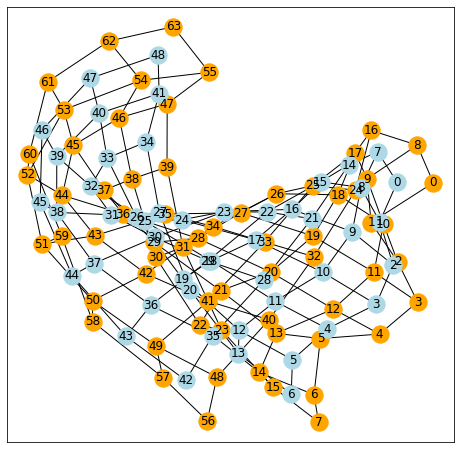

In [13]:
gpn = GrowingPlanarNetwork()
gpn.init_square(8)
gpn.show_all(figsize=(8, 8))

In [14]:
# random.seed(0+0)
# np.random.seed(0+0)
# ccls = TriStateModelFactory(diff_values_RG_GP=[1., 1., 1., 0.85, 0.6])
# exp = Experiment(time_step=0.5, verbose=False, start_population=3, cell_cls=ccls.generate,
#                  check=False, cls_=Brain, safe_mode=False)
# exp.run()

In [15]:
# with Profiler():
#     random.seed(0+0)
#     np.random.seed(0+0)
#     ccls = BiStateModelFactory(tc_coeff_RG=[1., 1., 1., 1., 1.])
#     exp = Experiment(time_step=0.5, verbose=False, start_population=3, cell_cls=ccls.generate,
#                      check=False, cls_=Brain)
#     exp.run()

In [16]:
random.seed(0+0)
np.random.seed(0+0)
ccls = BiStateLIModelFactory(tc_coeff_RG=[1., 1., 1., 1., 1.])
bb = Brain(time_step=0.5, verbose=False, start_population=3, cell_cls=ccls.generate, check=False)
bb.run()

Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density
Correct for density


In [17]:
gpn = bb.gpn
couple_ngb = [(len(gpn.ngb(x)), x) for x in gpn.G.nodes if len(gpn.ngb(x)) > 5]
couple_ngb

[(6, 2756),
 (6, 2939),
 (6, 3141),
 (6, 3208),
 (6, 3319),
 (6, 3362),
 (6, 3375),
 (6, 3576),
 (6, 3610),
 (6, 3630),
 (6, 3641),
 (6, 3656),
 (6, 3673),
 (6, 3735),
 (7, 3745),
 (6, 3749),
 (6, 3802),
 (6, 3818),
 (6, 3840),
 (6, 3895),
 (6, 3976),
 (6, 3986),
 (6, 4014),
 (7, 4025),
 (6, 4030),
 (6, 4055),
 (6, 4081),
 (6, 4096),
 (6, 4149),
 (6, 4185)]

In [18]:
bb.gpn.density(), bb.gpn.perimeter(), bb.gpn.G.number_of_nodes()

(0.3380102040816326, 28, 265)

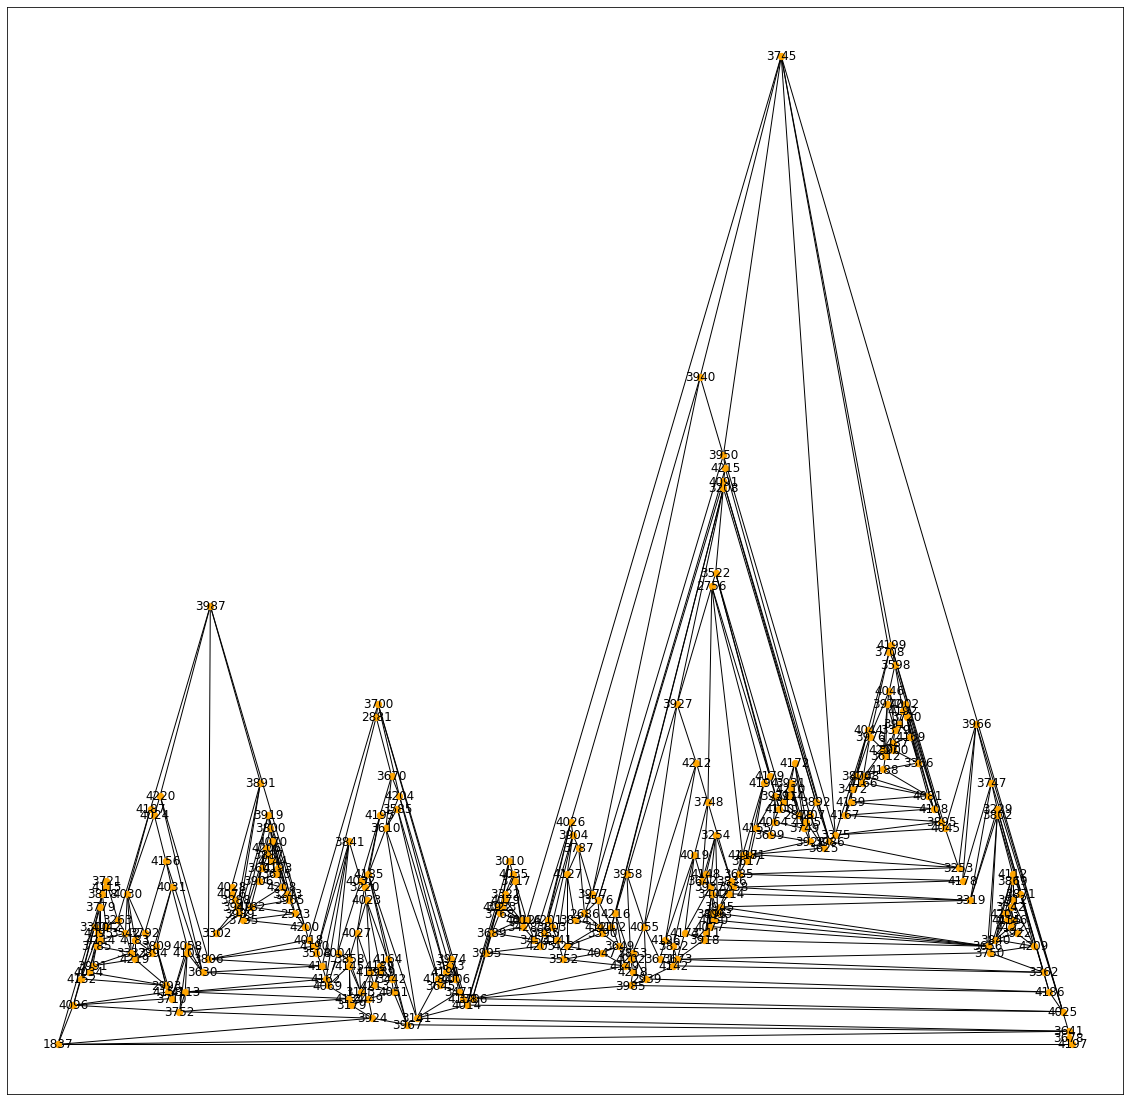

In [19]:
import networkx as nx
def sh(G, k=5, iterations=1000):
    plt.figure(figsize=(20, 20))
    # pos = nx.spring_layout(G, k=k, iterations=iterations)
    pos = nx.planar_layout(G)
    # pos = nx.spring_layout(G, k=k, iterations=iterations, pos=pos)
    # pos = nx.kamada_kawai_layout(G, pos=pos, scale=0.1)
    nx.draw_networkx(G, pos, node_color="orange", node_size=40)
    
sh(bb.gpn.G, k=0.01, iterations=1)

In [20]:
pos = nx.planar_layout(bb.gpn.G)
pos

{1837: array([-0.99879547, -0.0988428 ]),
 2523: array([-0.53139653, -0.02284297]),
 2686: array([ 0.03860218, -0.02284297]),
 2756: array([0.28940161, 0.1671566 ]),
 2878: array([0.46040122, 0.0341569 ]),
 2881: array([-0.37179689,  0.09115677]),
 2894: array([-0.8125959 , -0.04564292]),
 2939: array([ 0.1602019 , -0.06084288]),
 2993: array([-0.78599596, -0.06464287]),
 3010: array([-0.10959749,  0.00755696]),
 3141: array([-0.29199707, -0.08364283]),
 3143: array([-0.40219683, -0.06844286]),
 3179: array([-0.42119678, -0.07604285]),
 3208: array([0.31220156, 0.22415647]),
 3220: array([-0.39459684, -0.007643  ]),
 3229: array([0.85180034, 0.0379569 ]),
 3243: array([-0.5465965 , -0.01144299]),
 3253: array([0.77580051, 0.00375697]),
 3254: array([0.29700159, 0.02275693]),
 3263: array([-0.88099574, -0.02664296]),
 3300: array([-0.92659564, -0.03044295]),
 3302: array([-0.68719618, -0.03424294]),
 3315: array([0.43000129, 0.04175689]),
 3319: array([ 0.79860046, -0.01524298]),
 3322:

In [21]:
lay2 = [list(x) for x in pos.values()]

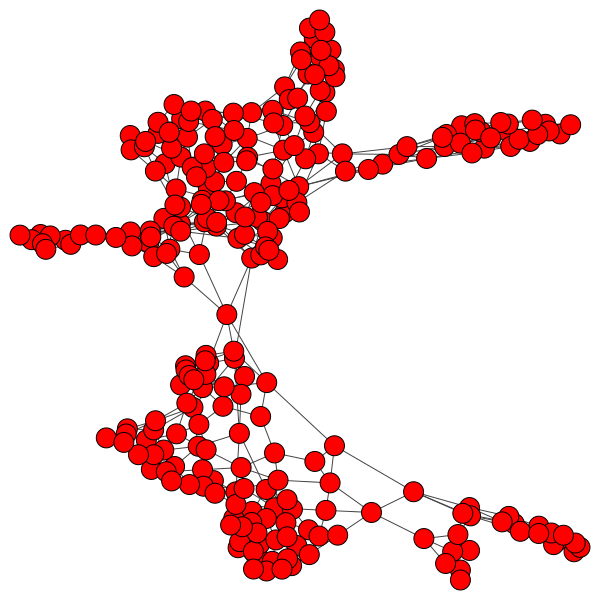

In [22]:
import igraph as ig
# convertir le graph
g = ig.Graph.from_networkx(bb.gpn.G)
# calculer le spring

# calculer le davidson harel
g.layout_davidson_harel(seed=lay2, maxiter=1, fineiter=-1)

# plotter
ig.plot(g)

In [23]:
lay = g.layout()
lay.__dict__

{'_coords': [[-3.8825479930365656, 12.262068798290114],
  [-29.707192987995324, 18.86297495486821],
  [21.809403931261308, -18.286640297507883],
  [19.33859183167261, -5.044199609576334],
  [31.006096070887725, -3.7368400615613013],
  [-13.37719549630888, 6.799631813024819],
  [-11.979881483532594, 27.241478439352555],
  [11.27061327630699, -9.705332458018953],
  [-8.619038714677837, 25.971679166492393],
  [0.7396722230153255, -11.025414235871345],
  [-5.697250187227584, 0.9498082114811578],
  [-11.174589164401466, 13.007101229320938],
  [-9.579006944085384, 14.060095251795238],
  [21.65296140000631, -9.570752950357523],
  [-11.116914016323888, 8.38016345890292],
  [6.250944932193169, -11.281349579653751],
  [-35.80394351975532, 20.801885331198392],
  [19.09935488303233, -11.82959891493548],
  [7.060208735975634, -4.687932364211553],
  [-11.291991339227545, 23.91609385714411],
  [-5.917852122477205, 22.293306945302216],
  [-30.23577617029867, 24.494138606113154],
  [29.047818264939572,

In [24]:
lay._coords = lay2

In [25]:
help(g.layout_davidson_harel)

Help on method layout_davidson_harel in module igraph:

layout_davidson_harel(*args, **kwds) method of igraph.Graph instance
    Places the vertices on a 2D plane according to the Davidson-Harel layout
    algorithm.
    
    The algorithm uses simulated annealing and a sophisticated energy function,
    which is unfortunately hard to parameterize for different graphs. The
    original publication did not disclose any parameter values, and the ones
    below were determined by experimentation.
    
    The algorithm consists of two phases: an annealing phase and a fine-tuning
    phase. There is no simulated annealing in the second phase.
    
    @param seed: if C{None}, uses a random starting layout for the algorithm.
      If a matrix (list of lists), uses the given matrix as the starting
      position.
    @param maxiter: Number of iterations to perform in the annealing phase.
    @param fineiter: Number of iterations to perform in the fine-tuning phase.
      Negative numbers set

In [26]:
G = bb.gpn.G

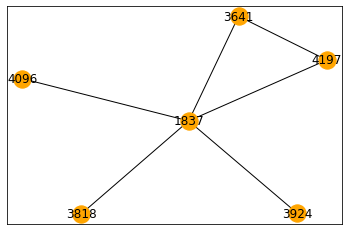

In [27]:
E = nx.ego_graph(G, 1837, radius=1)
nx.draw_networkx(E, node_color="orange")

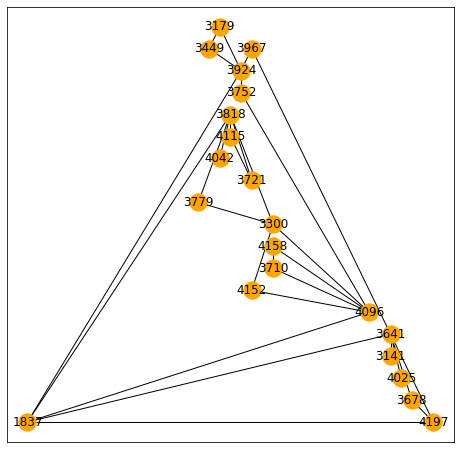

In [28]:
plt.figure(figsize=(8, 8))
E = nx.ego_graph(G, 1837, radius=2)
pos = nx.planar_layout(E)
nx.draw_networkx(E, node_color="orange", pos=pos)

In [30]:
list_inner = [gpn.G.degree(n) for n in gpn.G.nodes if not gpn.is_border_node(n)]
list_outer = [gpn.G.degree(n) for n in gpn.G.nodes if gpn.is_border_node(n)]

(array([ 19.,   0.,   0.,  86.,   0.,   0., 108.,   0.,   0.,  24.]),
 array([3. , 3.3, 3.6, 3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ]),
 <BarContainer object of 10 artists>)

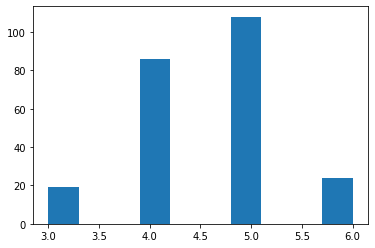

In [31]:
plt.hist(list_inner)

(array([4., 0., 5., 0., 7., 0., 6., 0., 4., 2.]),
 array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ]),
 <BarContainer object of 10 artists>)

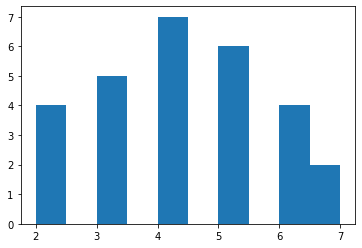

In [32]:
plt.hist(list_outer)

In [29]:
a, b, c, d = 1837, 4210, 2878, 3922
for edge in [(a, b), (b, c), (c, d), (d, a)]:
    assert edge in E.edges

AssertionError: 